## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [41]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [42]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib
import os

### Global Variables

In [43]:
# Model settings
modelName = 'stockScreenerV11.0'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = 'NVO'  # 'ALL' for all tickers, 'None' for no prediction

# Training parameters
trainingSize = 200  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
catNames = ['Date']
contNames = ['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'EV/EBIT', 'ROIC']
batchSize = 256
epochs = 25

# Testing parameters
testSize = 300  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Remove Duplicate Tickers

In [44]:
df = pd.read_csv(testFolder / 'tickers.csv')
df.drop_duplicates().to_csv(testFolder / 'tickers.csv', index=False)

#### Utility Functions

In [45]:
def getIndustry(tickerSymbol):
    """Fetches the industry of the given ticker symbol."""
    try:
        return yf.Ticker(tickerSymbol).info.get('industry', 'Unknown')
    except Exception as e:
        return 'Error'

In [46]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Future Year Change']]

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [47]:
def getEVComponents(tickerSymbol):
    """Fetches static EV components (total debt, cash, shares outstanding)."""
    try:
        info = yf.Ticker(tickerSymbol).info
        return info.get('totalDebt', 0), info.get('totalCash', 0), info.get('sharesOutstanding', None)
    except Exception as e:
        return None, None, None

In [48]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [49]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            totalDebt, cash, sharesOutstanding = getEVComponents(ticker)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [50]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [51]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception as e:

        return pd.DataFrame()

#### Download and Process Historical Data

In [52]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = getIndustry(ticker)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

Processing NEOG...


$HNR: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing HNR...
No data found for HNR (10y)
Skipped HNR - insufficient data
Processing GM-B...


$GM-B: possibly delisted; no timezone found


No data found for GM-B (10y)
Skipped GM-B - insufficient data
Processing BCPC...
Processing AHT...
Processing KELYB...
Processing PKBK...
Processing BCF...
Insufficient data for BCF (1 rows)
Skipped BCF - insufficient data
Processing DSU...
Processing HXL...
Processing MTX...
Processing E...
Processing GOGO...
Processing BEP...
Processing ARQL...


$ARQL: possibly delisted; no timezone found


No data found for ARQL (10y)
Skipped ARQL - insufficient data
Processing GLAD...
Processing WIN...


$WIN: possibly delisted; no timezone found


No data found for WIN (10y)
Skipped WIN - insufficient data
Processing STI-E...


$STI-E: possibly delisted; no timezone found
$NBG: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for STI-E (10y)
Skipped STI-E - insufficient data
Processing NBG...
No data found for NBG (10y)
Skipped NBG - insufficient data
Processing TUP...


$TUP: possibly delisted; no timezone found
$GMT: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for TUP (10y)
Skipped TUP - insufficient data
Processing GMT...
No data found for GMT (10y)
Skipped GMT - insufficient data
Processing NASB...
Processing LHO-H...


$LHO-H: possibly delisted; no timezone found
$CGG: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for LHO-H (10y)
Skipped LHO-H - insufficient data
Processing CGG...
No data found for CGG (10y)
Skipped CGG - insufficient data
Processing GKM...
Insufficient data for GKM (135 rows)
Skipped GKM - insufficient data
Processing DELL...
Processing GTS...


$GTS: possibly delisted; no timezone found


No data found for GTS (10y)
Skipped GTS - insufficient data
Processing NTG...
Processing SKBI...


$SKBI: possibly delisted; no timezone found


No data found for SKBI (10y)
Skipped SKBI - insufficient data
Processing CBB...


$CBB: possibly delisted; no timezone found


No data found for CBB (10y)
Skipped CBB - insufficient data
Processing GSK...
Processing KOF...
Processing HSII...


$DVR: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing DVR...
No data found for DVR (10y)
Skipped DVR - insufficient data
Processing KAMN...


$KAMN: possibly delisted; no timezone found


No data found for KAMN (10y)
Skipped KAMN - insufficient data
Processing SRC...


$SRC: possibly delisted; no timezone found


No data found for SRC (10y)
Skipped SRC - insufficient data
Processing MXF...
Processing ALG...
Processing OXM...
Processing NAC...


$HNT: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing HNT...
No data found for HNT (10y)
Skipped HNT - insufficient data
Processing MAA...
Processing PENN...


$KYO: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing KYO...
No data found for KYO (10y)
Skipped KYO - insufficient data
Processing PSCI...
Processing STND...


$STND: possibly delisted; no timezone found


No data found for STND (10y)
Skipped STND - insufficient data
Processing PNRG...
Processing PDM...
Processing UNM...
Processing ANAC...


$ANAC: possibly delisted; no timezone found


No data found for ANAC (10y)
Skipped ANAC - insufficient data
Processing AIF...


$AIF: possibly delisted; no timezone found


No data found for AIF (10y)
Skipped AIF - insufficient data
Processing TDC...
Processing ATRI...


$ATRI: possibly delisted; no timezone found


No data found for ATRI (10y)
Skipped ATRI - insufficient data
Processing SHG...
Processing KVHI...
Processing TMS...
Processing DUKH...
Insufficient data for DUKH (136 rows)
Skipped DUKH - insufficient data
Processing VRNG...


$VRNG: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for VRNG (10y)
Skipped VRNG - insufficient data
Processing SN...
Processing FNGN...


$FNGN: possibly delisted; no timezone found


No data found for FNGN (10y)
Skipped FNGN - insufficient data
Processing PTX...


$PTX: possibly delisted; no timezone found


No data found for PTX (10y)
Skipped PTX - insufficient data
Processing LPX...
Processing CLVS...


$CLVS: possibly delisted; no timezone found


No data found for CLVS (10y)
Skipped CLVS - insufficient data
Processing IBCP...
Processing NYMT...
Processing HSTM...
Processing INTG...
Processing LXU...
Processing ADI...


$KMP: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing KMP...
No data found for KMP (10y)
Skipped KMP - insufficient data
Processing NI...
Processing DLR-E...


$DLR-E: possibly delisted; no timezone found


No data found for DLR-E (10y)
Skipped DLR-E - insufficient data
Processing ADUS...
Processing NVEC...
Processing NWBI...
Processing JOE...


$REMY: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing REMY...
No data found for REMY (10y)
Skipped REMY - insufficient data
Processing RBS-P...


$RBS-P: possibly delisted; no timezone found


No data found for RBS-P (10y)
Skipped RBS-P - insufficient data
Processing BIOF...


$ASBC: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing ASBC...
No data found for ASBC (10y)
Skipped ASBC - insufficient data
Processing VNR...


$VNR: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for VNR (10y)
Skipped VNR - insufficient data
Processing XOM...
Processing NBD...


$OMX: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Insufficient data for NBD (293 rows)
Skipped NBD - insufficient data
Processing OMX...
No data found for OMX (10y)
Skipped OMX - insufficient data
Processing EAGLU...


$EAGLU: possibly delisted; no timezone found


No data found for EAGLU (10y)
Skipped EAGLU - insufficient data
Processing EHI...


$MSLI: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing MSLI...
No data found for MSLI (10y)
Skipped MSLI - insufficient data
Processing NSPH...


$NSPH: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for NSPH (10y)
Skipped NSPH - insufficient data
Processing PTEN...
Processing CEA...


$CEA: possibly delisted; no timezone found
$N: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for CEA (10y)
Skipped CEA - insufficient data
Processing N...
No data found for N (10y)
Skipped N - insufficient data
Processing CPAH...


$CPAH: possibly delisted; no timezone found


No data found for CPAH (10y)
Skipped CPAH - insufficient data
Processing HIL...


$HIL: possibly delisted; no timezone found


No data found for HIL (10y)
Skipped HIL - insufficient data
Processing UIHC...


$UIHC: possibly delisted; no timezone found
$OPXA: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for UIHC (10y)
Skipped UIHC - insufficient data
Processing OPXA...
No data found for OPXA (10y)
Skipped OPXA - insufficient data
Processing PRGX...


$PRGX: possibly delisted; no timezone found
$OKSB: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for PRGX (10y)
Skipped PRGX - insufficient data
Processing OKSB...
No data found for OKSB (10y)
Skipped OKSB - insufficient data
Processing RVLT...


$RVLT: possibly delisted; no timezone found


No data found for RVLT (10y)
Skipped RVLT - insufficient data
Processing BOH...
Processing NSLP...


$NSLP: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for NSLP (10y)
Skipped NSLP - insufficient data
Processing GEL...
Processing INN-A...


$INN-A: possibly delisted; no timezone found


No data found for INN-A (10y)
Skipped INN-A - insufficient data
Processing PFG-B...


$PFG-B: possibly delisted; no timezone found


No data found for PFG-B (10y)
Skipped PFG-B - insufficient data
Processing MFL...


$MFL: possibly delisted; no timezone found


No data found for MFL (10y)
Skipped MFL - insufficient data
Processing SLCA...


$SLCA: possibly delisted; no timezone found


No data found for SLCA (10y)
Skipped SLCA - insufficient data
Processing CRK...


$ALCS: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing ALCS...
No data found for ALCS (10y)
Skipped ALCS - insufficient data
Processing QTEC...
Processing WBC...


$WBC: possibly delisted; no timezone found
$JHP: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for WBC (10y)
Skipped WBC - insufficient data
Processing JHP...
No data found for JHP (10y)
Skipped JHP - insufficient data
Processing PHIIK...


$PHIIK: possibly delisted; no timezone found


No data found for PHIIK (10y)
Skipped PHIIK - insufficient data
Processing VRML...


$VRML: possibly delisted; no timezone found


No data found for VRML (10y)
Skipped VRML - insufficient data
Processing AET...


$XFP: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing XFP...
No data found for XFP (10y)
Skipped XFP - insufficient data
Processing IRC...
Insufficient data for IRC (37 rows)
Skipped IRC - insufficient data
Processing ACAD...
Processing JPM-D...


$JPM-D: possibly delisted; no timezone found


No data found for JPM-D (10y)
Skipped JPM-D - insufficient data
Processing TRNS...
Processing SAN-E...


$SAN-E: possibly delisted; no timezone found


No data found for SAN-E (10y)
Skipped SAN-E - insufficient data
Processing FL...
Processing LCUT...


$OKS: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing OKS...
No data found for OKS (10y)
Skipped OKS - insufficient data
Processing MPA...
Processing SOHO...
Processing LARK...
Processing AMNB...


$AMNB: possibly delisted; no timezone found


No data found for AMNB (10y)
Skipped AMNB - insufficient data
Processing HDS...


$HDS: possibly delisted; no timezone found


No data found for HDS (10y)
Skipped HDS - insufficient data
Processing CI...
Processing HPI...
Processing TWER...
Processing NOW...
Processing BPK...
Processing DFT-B...


$DFT-B: possibly delisted; no timezone found


No data found for DFT-B (10y)
Skipped DFT-B - insufficient data
Processing MS-A...


$MS-A: possibly delisted; no timezone found


No data found for MS-A (10y)
Skipped MS-A - insufficient data
Processing ELON...
Processing DV...


$KEF: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing KEF...
No data found for KEF (10y)
Skipped KEF - insufficient data
Processing FBHS...


$FBHS: possibly delisted; no timezone found


No data found for FBHS (10y)
Skipped FBHS - insufficient data
Processing EFR...
Processing UTX...


$UTX: possibly delisted; no timezone found
$SLH: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for UTX (10y)
Skipped UTX - insufficient data
Processing SLH...
No data found for SLH (10y)
Skipped SLH - insufficient data
Processing HIBB...


$HIBB: possibly delisted; no timezone found


No data found for HIBB (10y)
Skipped HIBB - insufficient data
Processing KTF...
Processing LOGI...
Processing TSU...


$TSU: possibly delisted; no timezone found


No data found for TSU (10y)
Skipped TSU - insufficient data
Processing ANGI...
Processing FSS...
Processing OCR-A...


$OCR-A: possibly delisted; no timezone found


No data found for OCR-A (10y)
Skipped OCR-A - insufficient data
Processing GRPN...
Processing SIGA...
Processing EMC...
Processing CYBE...


$CYBE: possibly delisted; no timezone found


No data found for CYBE (10y)
Skipped CYBE - insufficient data
Processing UIS...


$PMC: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing PMC...
No data found for PMC (10y)
Skipped PMC - insufficient data
Processing FFBC...
Processing COF...
Processing WTBA...
Processing SPG...
Processing ZBRA...


$MDAS: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing MDAS...
No data found for MDAS (10y)
Skipped MDAS - insufficient data
Processing EBTC...
Processing QNST...
Processing BZT...


$BZT: possibly delisted; no timezone found


No data found for BZT (10y)
Skipped BZT - insufficient data
Processing ONEQ...
Processing PAG...
Processing CYN-C...


$CYN-C: possibly delisted; no timezone found


No data found for CYN-C (10y)
Skipped CYN-C - insufficient data
Processing PB...
Processing ALCO...
Processing CNQ...
Processing UCBA...
Processing HPOL...
Insufficient data for HPOL (6 rows)
Skipped HPOL - insufficient data
Processing OPHC...
Processing ARRS...


$ARRS: possibly delisted; no timezone found


No data found for ARRS (10y)
Skipped ARRS - insufficient data
Processing CAJ...


$CAJ: possibly delisted; no timezone found


No data found for CAJ (10y)
Skipped CAJ - insufficient data
Processing NSC...
Processing UHT...
Processing CEVA...
Processing CLSN...


$CLSN: possibly delisted; no timezone found


No data found for CLSN (10y)
Skipped CLSN - insufficient data
Processing HVT...
Processing LCNB...
Processing CUK...
Processing PSTI...


$PSTI: possibly delisted; no timezone found


No data found for PSTI (10y)
Skipped PSTI - insufficient data
Processing IPAS...
Processing MGA...
Processing CVRR...
Processing THRD...
Processing CL...
Processing BRK.B...


$BRK.B: possibly delisted; no timezone found


No data found for BRK.B (10y)
Skipped BRK.B - insufficient data
Processing AEM...
Processing ENSG...
Processing LOPE...
Processing EIX...


$SUSS: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing SUSS...
No data found for SUSS (10y)
Skipped SUSS - insufficient data
Processing BPT...


$MEAS: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


Processing MEAS...
No data found for MEAS (10y)
Skipped MEAS - insufficient data
Processing CHMG...
Processing BCS-C...


$BCS-C: possibly delisted; no timezone found


No data found for BCS-C (10y)
Skipped BCS-C - insufficient data
Processing WBK...


$WBK: possibly delisted; no timezone found
$IOC: possibly delisted; no price data found  (1d 2014-01-25 00:00:00 -> 2025-01-25)


No data found for WBK (10y)
Skipped WBK - insufficient data
Processing IOC...
No data found for IOC (10y)
Skipped IOC - insufficient data
Processing EAC...


$EAC: possibly delisted; no timezone found


No data found for EAC (10y)
Skipped EAC - insufficient data

Columns in final dataset: ['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Future Year Change', 'Ticker', 'Industry', 'EV/EBIT', 'ROIC']
Saved training data with 251300 rows


## Model Training

In [53]:
TRAINING_CUTOFF = pd.to_datetime('2023-01-01').tz_localize('America/New_York')

df = pd.read_csv(dataFolder / trainingData)
dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

# Convert 'Date' to datetime and drop invalid
dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce')
dfCleaned = dfCleaned.dropna(subset=['Date'])

# Clean 'EV/EBIT' and reset index
dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
dfCleaned = dfCleaned.reset_index(drop=True)  # Reset index here
dfCleaned.to_csv(dataFolder / trainingData, index=False)

# Check for empty data
if dfCleaned.empty:
    raise ValueError("The cleaned DataFrame is empty.")

# Create splits with valid indices
train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
valid_mask = ~train_mask
splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

if not splits[0] or not splits[1]:
    raise ValueError("Empty training or validation split.")

# Proceed with TabularPandas
to = TabularPandas(
    dfCleaned, 
    procs=[Categorify, FillMissing, Normalize],
    y_names='Future Year Change',
    cat_names=['Industry'], 
    cont_names=['Open', 'Close', 'EV/EBIT', 'ROIC'],
    splits=splits
)

dls = to.dataloaders(bs=batchSize)

/var/folders/ch/yfh31z5s3cq4cw_md59n4qw40000gn/T/ipykernel_28403/3198407231.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce')


epoch,train_loss,valid_loss,_rmse,mae,time
0,20.865858,0.175011,0.418344,0.293407,00:20
1,91.295052,0.311161,0.557818,0.366067,00:16
2,100.858894,0.295086,0.543218,0.347043,00:16
3,300.577789,1.559572,1.248828,0.657242,00:20
4,101.181557,0.412423,0.642201,0.390214,00:18
5,95.866394,0.348783,0.590578,0.388448,00:17
6,28.613924,0.212684,0.461177,0.307590,00:14
7,154.528458,0.525826,0.725139,0.373420,00:16
8,74.310143,0.241451,0.491377,0.298305,00:17
9,410.804047,2.060647,1.435495,0.518912,00:18


Model training complete


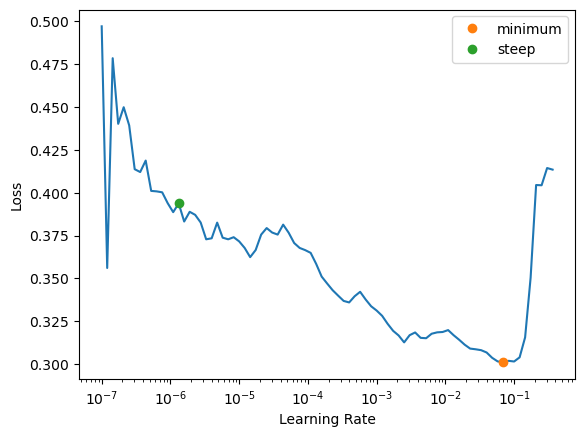

In [54]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Train
    learn.fit_one_cycle(epochs, lr_max=3e-3)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$AVNR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AVNR: No historical data available for AVNR around 2024-01-26.


$SCH-B: possibly delisted; no timezone found


Error fetching data for SCH-B: No historical data available for SCH-B around 2024-01-26.


$LUB: possibly delisted; no timezone found


Error fetching data for LUB: No historical data available for LUB around 2024-01-26.


$ABR-PA: possibly delisted; no timezone found


Error fetching data for ABR-PA: No historical data available for ABR-PA around 2024-01-26.


$UTX-A: possibly delisted; no timezone found


Error fetching data for UTX-A: No historical data available for UTX-A around 2024-01-26.


$CONN: possibly delisted; no timezone found


Error fetching data for CONN: No historical data available for CONN around 2024-01-26.


$GHL: possibly delisted; no timezone found


Error fetching data for GHL: No historical data available for GHL around 2024-01-26.


$EDI: possibly delisted; no timezone found


Error fetching data for EDI: No historical data available for EDI around 2024-01-26.


$PSA-P: possibly delisted; no timezone found


Error fetching data for PSA-P: No historical data available for PSA-P around 2024-01-26.


$ARCW: possibly delisted; no timezone found
$OME: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ARCW: No historical data available for ARCW around 2024-01-26.
Error fetching data for OME: No historical data available for OME around 2024-01-26.


$ZOOM: possibly delisted; no timezone found
$CPLA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ZOOM: No historical data available for ZOOM around 2024-01-26.
Error fetching data for CPLA: No historical data available for CPLA around 2024-01-26.


$SLXP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLXP: No historical data available for SLXP around 2024-01-26.


$NNN-D: possibly delisted; no timezone found


Error fetching data for NNN-D: No historical data available for NNN-D around 2024-01-26.


$TUES: possibly delisted; no timezone found


Error fetching data for TUES: No historical data available for TUES around 2024-01-26.


$CRZO: possibly delisted; no timezone found
$ADVS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CRZO: No historical data available for CRZO around 2024-01-26.
Error fetching data for ADVS: No historical data available for ADVS around 2024-01-26.


$PL-E: possibly delisted; no timezone found


Error fetching data for PL-E: No historical data available for PL-E around 2024-01-26.


$ATU: possibly delisted; no timezone found
$HAST: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ATU: No historical data available for ATU around 2024-01-26.
Error fetching data for HAST: No historical data available for HAST around 2024-01-26.


$NEWS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NEWS: No historical data available for NEWS around 2024-01-26.


$IFSM: possibly delisted; no timezone found


Error fetching data for IFSM: No historical data available for IFSM around 2024-01-26.


$ALIM: possibly delisted; no timezone found


Error fetching data for ALIM: No historical data available for ALIM around 2024-01-26.


$HEP: possibly delisted; no timezone found
$NHTB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HEP: No historical data available for HEP around 2024-01-26.
Error fetching data for NHTB: No historical data available for NHTB around 2024-01-26.


$DRE-L: possibly delisted; no timezone found


Error fetching data for DRE-L: No historical data available for DRE-L around 2024-01-26.


$C-C: possibly delisted; no timezone found
$PVTBP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for C-C: No historical data available for C-C around 2024-01-26.
Error fetching data for PVTBP: No historical data available for PVTBP around 2024-01-26.


$MIE: possibly delisted; no timezone found


Error fetching data for MIE: No historical data available for MIE around 2024-01-26.


$VLTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for VLTR: No historical data available for VLTR around 2024-01-26.


$ACST: possibly delisted; no timezone found
$OUTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ACST: No historical data available for ACST around 2024-01-26.
Error fetching data for OUTR: No historical data available for OUTR around 2024-01-26.


$PKD: possibly delisted; no timezone found


Error fetching data for PKD: No historical data available for PKD around 2024-01-26.


$QADA: possibly delisted; no timezone found


Error fetching data for QADA: No historical data available for QADA around 2024-01-26.


$ISH-A: possibly delisted; no timezone found


Error fetching data for ISH-A: No historical data available for ISH-A around 2024-01-26.


$MY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MY: No historical data available for MY around 2024-01-26.


$HGG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HGG: No historical data available for HGG around 2024-01-26.


$MACK: possibly delisted; no timezone found


Error fetching data for MACK: No historical data available for MACK around 2024-01-26.


$ACH: possibly delisted; no timezone found


Error fetching data for ACH: No historical data available for ACH around 2024-01-26.


$PHII: possibly delisted; no timezone found


Error fetching data for PHII: No historical data available for PHII around 2024-01-26.


$INN-C: possibly delisted; no timezone found


Error fetching data for INN-C: No historical data available for INN-C around 2024-01-26.


$GGP-A: possibly delisted; no timezone found


Error fetching data for GGP-A: No historical data available for GGP-A around 2024-01-26.


$JCOM: possibly delisted; no timezone found
$BBNK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JCOM: No historical data available for JCOM around 2024-01-26.
Error fetching data for BBNK: No historical data available for BBNK around 2024-01-26.


$OILT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26) (Yahoo error = "Data doesn't exist for startDate = 1703653200, endDate = 1706245200")


Error fetching data for OILT: No historical data available for OILT around 2024-01-26.


$COSI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$RKUS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for COSI: No historical data available for COSI around 2024-01-26.
Error fetching data for RKUS: No historical data available for RKUS around 2024-01-26.


$ATE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$BWP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ATE: No historical data available for ATE around 2024-01-26.
Error fetching data for BWP: No historical data available for BWP around 2024-01-26.


$UAM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for UAM: No historical data available for UAM around 2024-01-26.


$CIR: possibly delisted; no timezone found


Error fetching data for CIR: No historical data available for CIR around 2024-01-26.


$SNTS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SNTS: No historical data available for SNTS around 2024-01-26.


$BASI: possibly delisted; no timezone found


Error fetching data for BASI: No historical data available for BASI around 2024-01-26.


$XPLR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for XPLR: No historical data available for XPLR around 2024-01-26.


$ATX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$LIQD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ATX: No historical data available for ATX around 2024-01-26.
Error fetching data for LIQD: No historical data available for LIQD around 2024-01-26.


$SLTM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLTM: No historical data available for SLTM around 2024-01-26.


$CHKE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CHKE: No historical data available for CHKE around 2024-01-26.


$DRE-K: possibly delisted; no timezone found
$PYS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DRE-K: No historical data available for DRE-K around 2024-01-26.
Error fetching data for PYS: No historical data available for PYS around 2024-01-26.


$KAP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for KAP: No historical data available for KAP around 2024-01-26.


$SYMX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SYMX: No historical data available for SYMX around 2024-01-26.


$AES-PC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AES-PC: No historical data available for AES-PC around 2024-01-26.


$HTA: possibly delisted; no timezone found


Error fetching data for HTA: No historical data available for HTA around 2024-01-26.


$PPL-W: possibly delisted; no timezone found
$HYL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PPL-W: No historical data available for PPL-W around 2024-01-26.
Error fetching data for HYL: No historical data available for HYL around 2024-01-26.


$FXEN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FXEN: No historical data available for FXEN around 2024-01-26.


$ASCA: possibly delisted; no timezone found


Error fetching data for ASCA: No historical data available for ASCA around 2024-01-26.


$TTM: possibly delisted; no timezone found


Error fetching data for TTM: No historical data available for TTM around 2024-01-26.


$PTR: possibly delisted; no timezone found


Error fetching data for PTR: No historical data available for PTR around 2024-01-26.


$AMRB: possibly delisted; no timezone found


Error fetching data for AMRB: No historical data available for AMRB around 2024-01-26.


$BPFHW: possibly delisted; no timezone found


Error fetching data for BPFHW: No historical data available for BPFHW around 2024-01-26.


$DVD: possibly delisted; no timezone found


Error fetching data for DVD: No historical data available for DVD around 2024-01-26.


$PSB-T: possibly delisted; no timezone found
$QRE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PSB-T: No historical data available for PSB-T around 2024-01-26.
Error fetching data for QRE: No historical data available for QRE around 2024-01-26.


$PSA-T: possibly delisted; no timezone found


Error fetching data for PSA-T: No historical data available for PSA-T around 2024-01-26.


$NEE-J: possibly delisted; no timezone found


Error fetching data for NEE-J: No historical data available for NEE-J around 2024-01-26.


$AMP-A: possibly delisted; no timezone found


Error fetching data for AMP-A: No historical data available for AMP-A around 2024-01-26.


$TMK: possibly delisted; no timezone found


Error fetching data for TMK: No historical data available for TMK around 2024-01-26.


$ROYT: possibly delisted; no timezone found
$XVG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ROYT: No historical data available for ROYT around 2024-01-26.
Error fetching data for XVG: No historical data available for XVG around 2024-01-26.


$FTT: possibly delisted; no timezone found
$CWEI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$KMR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FTT: No historical data available for FTT around 2024-01-26.
Error fetching data for CWEI: No historical data available for CWEI around 2024-01-26.
Error fetching data for KMR: No historical data available for KMR around 2024-01-26.


$ABC: possibly delisted; no timezone found


Error fetching data for ABC: No historical data available for ABC around 2024-01-26.


$VAL.P: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$WAC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$MSPD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for VAL.P: No historical data available for VAL.P around 2024-01-26.
Error fetching data for WAC: No historical data available for WAC around 2024-01-26.
Error fetching data for MSPD: No historical data available for MSPD around 2024-01-26.


$CAP: possibly delisted; no timezone found
$AVG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CAP: No historical data available for CAP around 2024-01-26.
Error fetching data for AVG: No historical data available for AVG around 2024-01-26.


$SMM: possibly delisted; no timezone found
$CYNO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SMM: No historical data available for SMM around 2024-01-26.
Error fetching data for CYNO: No historical data available for CYNO around 2024-01-26.


$ELGX: possibly delisted; no timezone found


Error fetching data for ELGX: No historical data available for ELGX around 2024-01-26.


$ZMH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ZMH: No historical data available for ZMH around 2024-01-26.


$LEAP: possibly delisted; no timezone found


Error fetching data for LEAP: No historical data available for LEAP around 2024-01-26.


$NEA-C: possibly delisted; no timezone found


Error fetching data for NEA-C: No historical data available for NEA-C around 2024-01-26.


$BRS: possibly delisted; no timezone found


Error fetching data for BRS: No historical data available for BRS around 2024-01-26.


$ROICU: possibly delisted; no timezone found


Error fetching data for ROICU: No historical data available for ROICU around 2024-01-26.


$RALY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RALY: No historical data available for RALY around 2024-01-26.


$ISH-B: possibly delisted; no timezone found
$GUID: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ISH-B: No historical data available for ISH-B around 2024-01-26.
Error fetching data for GUID: No historical data available for GUID around 2024-01-26.


$USB-A: possibly delisted; no timezone found


Error fetching data for USB-A: No historical data available for USB-A around 2024-01-26.


$NEE-H: possibly delisted; no timezone found
$CPN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NEE-H: No historical data available for NEE-H around 2024-01-26.
Error fetching data for CPN: No historical data available for CPN around 2024-01-26.


$CERN: possibly delisted; no timezone found
$LLTC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CERN: No historical data available for CERN around 2024-01-26.
Error fetching data for LLTC: No historical data available for LLTC around 2024-01-26.


$AAN: possibly delisted; no timezone found


Error fetching data for AAN: No historical data available for AAN around 2024-01-26.


$NEE-G: possibly delisted; no timezone found
$RCPT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NEE-G: No historical data available for NEE-G around 2024-01-26.
Error fetching data for RCPT: No historical data available for RCPT around 2024-01-26.


$SQNM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$ANCI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SQNM: No historical data available for SQNM around 2024-01-26.
Error fetching data for ANCI: No historical data available for ANCI around 2024-01-26.


$SMMF: possibly delisted; no timezone found


Error fetching data for SMMF: No historical data available for SMMF around 2024-01-26.


$ACRX: possibly delisted; no timezone found


Error fetching data for ACRX: No historical data available for ACRX around 2024-01-26.


$FCTY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FCTY: No historical data available for FCTY around 2024-01-26.


$EMQ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EMQ: No historical data available for EMQ around 2024-01-26.


$C.B: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for C.B: No historical data available for C.B around 2024-01-26.


$MER-M: possibly delisted; no timezone found


Error fetching data for MER-M: No historical data available for MER-M around 2024-01-26.


$HUB.A: possibly delisted; no timezone found


Error fetching data for HUB.A: No historical data available for HUB.A around 2024-01-26.


$TICC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TICC: No historical data available for TICC around 2024-01-26.


$BODY: possibly delisted; no timezone found


Error fetching data for BODY: No historical data available for BODY around 2024-01-26.


$AGU: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AGU: No historical data available for AGU around 2024-01-26.


$ISF: possibly delisted; no timezone found


Error fetching data for ISF: No historical data available for ISF around 2024-01-26.


$NYNY: possibly delisted; no timezone found


Error fetching data for NYNY: No historical data available for NYNY around 2024-01-26.


$DDR-H: possibly delisted; no timezone found


Error fetching data for DDR-H: No historical data available for DDR-H around 2024-01-26.


$MEILW: possibly delisted; no timezone found


Error fetching data for MEILW: No historical data available for MEILW around 2024-01-26.


$TAYC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TAYC: No historical data available for TAYC around 2024-01-26.


$SPPRP: possibly delisted; no timezone found


Error fetching data for SPPRP: No historical data available for SPPRP around 2024-01-26.


$UPL: possibly delisted; no timezone found


Error fetching data for UPL: No historical data available for UPL around 2024-01-26.


$PSTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26) (Yahoo error = "Data doesn't exist for startDate = 1703653200, endDate = 1706245200")
$BKYF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PSTR: No historical data available for PSTR around 2024-01-26.
Error fetching data for BKYF: No historical data available for BKYF around 2024-01-26.


$NVGN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NVGN: No historical data available for NVGN around 2024-01-26.


$APF: possibly delisted; no timezone found


Error fetching data for APF: No historical data available for APF around 2024-01-26.


$TSS: possibly delisted; no timezone found


Error fetching data for TSS: No historical data available for TSS around 2024-01-26.


$ARE-E: possibly delisted; no timezone found
$LF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ARE-E: No historical data available for ARE-E around 2024-01-26.
Error fetching data for LF: No historical data available for LF around 2024-01-26.


$SPN: possibly delisted; no timezone found
$ANR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SPN: No historical data available for SPN around 2024-01-26.
Error fetching data for ANR: No historical data available for ANR around 2024-01-26.


$CNBC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CNBC: No historical data available for CNBC around 2024-01-26.


$EXPR: possibly delisted; no timezone found


Error fetching data for EXPR: No historical data available for EXPR around 2024-01-26.


$NUO: possibly delisted; no timezone found


Error fetching data for NUO: No historical data available for NUO around 2024-01-26.


$HW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$ISS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HW: No historical data available for HW around 2024-01-26.
Error fetching data for ISS: No historical data available for ISS around 2024-01-26.


$PRY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PRY: No historical data available for PRY around 2024-01-26.


$HNP: possibly delisted; no timezone found


Error fetching data for HNP: No historical data available for HNP around 2024-01-26.


$ZAGG: possibly delisted; no timezone found


Error fetching data for ZAGG: No historical data available for ZAGG around 2024-01-26.


$GTN.A: possibly delisted; no timezone found


Error fetching data for GTN.A: No historical data available for GTN.A around 2024-01-26.


$AMT-A: possibly delisted; no timezone found


Error fetching data for AMT-A: No historical data available for AMT-A around 2024-01-26.


$GEK: possibly delisted; no timezone found


Error fetching data for GEK: No historical data available for GEK around 2024-01-26.


$ADHD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ADHD: No historical data available for ADHD around 2024-01-26.


$ANDA: possibly delisted; no timezone found


Error fetching data for ANDA: No historical data available for ANDA around 2024-01-26.


$SNSS: possibly delisted; no timezone found


Error fetching data for SNSS: No historical data available for SNSS around 2024-01-26.


$NBTF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NBTF: No historical data available for NBTF around 2024-01-26.


$AHL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AHL: No historical data available for AHL around 2024-01-26.


$WTSL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$ARMH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for WTSL: No historical data available for WTSL around 2024-01-26.
Error fetching data for ARMH: No historical data available for ARMH around 2024-01-26.


$RIT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CHTP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RIT: No historical data available for RIT around 2024-01-26.
Error fetching data for CHTP: No historical data available for CHTP around 2024-01-26.


$APA-D: possibly delisted; no timezone found


Error fetching data for APA-D: No historical data available for APA-D around 2024-01-26.


$GARS: possibly delisted; no timezone found


Error fetching data for GARS: No historical data available for GARS around 2024-01-26.


$HTWO: possibly delisted; no timezone found


Error fetching data for HTWO: No historical data available for HTWO around 2024-01-26.


$STRI: possibly delisted; no timezone found


Error fetching data for STRI: No historical data available for STRI around 2024-01-26.


$COT: possibly delisted; no timezone found
$CNIT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for COT: No historical data available for COT around 2024-01-26.
Error fetching data for CNIT: No historical data available for CNIT around 2024-01-26.


$FSCFL: possibly delisted; no timezone found


Error fetching data for FSCFL: No historical data available for FSCFL around 2024-01-26.


$POPE: possibly delisted; no timezone found
$IBCA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for POPE: No historical data available for POPE around 2024-01-26.
Error fetching data for IBCA: No historical data available for IBCA around 2024-01-26.


$CRDS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$PTSX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$FSC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CRDS: No historical data available for CRDS around 2024-01-26.
Error fetching data for PTSX: No historical data available for PTSX around 2024-01-26.
Error fetching data for FSC: No historical data available for FSC around 2024-01-26.


$STSA: possibly delisted; no timezone found


Error fetching data for STSA: No historical data available for STSA around 2024-01-26.


$PNK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PNK: No historical data available for PNK around 2024-01-26.


$SOV-C: possibly delisted; no timezone found


Error fetching data for SOV-C: No historical data available for SOV-C around 2024-01-26.


$CETV: possibly delisted; no timezone found


Error fetching data for CETV: No historical data available for CETV around 2024-01-26.


$EXL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CKP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EXL: No historical data available for EXL around 2024-01-26.
Error fetching data for CKP: No historical data available for CKP around 2024-01-26.


$DGI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$NTE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DGI: No historical data available for DGI around 2024-01-26.
Error fetching data for NTE: No historical data available for NTE around 2024-01-26.


$ELRC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ELRC: No historical data available for ELRC around 2024-01-26.


$EBR.B: possibly delisted; no timezone found


Error fetching data for EBR.B: No historical data available for EBR.B around 2024-01-26.


$GOL: possibly delisted; no timezone found


Error fetching data for GOL: No historical data available for GOL around 2024-01-26.


$CTW: possibly delisted; no timezone found
$FBN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CTW: No historical data available for CTW around 2024-01-26.
Error fetching data for FBN: No historical data available for FBN around 2024-01-26.


$AIB: possibly delisted; no price data found  (period=1d)


Error fetching data for AIB: single positional indexer is out-of-bounds


$GDV-D: possibly delisted; no timezone found
$NTT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GDV-D: No historical data available for GDV-D around 2024-01-26.
Error fetching data for NTT: No historical data available for NTT around 2024-01-26.


$CBS: possibly delisted; no timezone found


Error fetching data for CBS: No historical data available for CBS around 2024-01-26.


$SEP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SEP: No historical data available for SEP around 2024-01-26.


$EEP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EEP: No historical data available for EEP around 2024-01-26.


$GSVC: possibly delisted; no timezone found


Error fetching data for GSVC: No historical data available for GSVC around 2024-01-26.


$HPT-D: possibly delisted; no timezone found
$PCCC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HPT-D: No historical data available for HPT-D around 2024-01-26.
Error fetching data for PCCC: No historical data available for PCCC around 2024-01-26.


$CSC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CSC: No historical data available for CSC around 2024-01-26.


$KHI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for KHI: No historical data available for KHI around 2024-01-26.


$ESC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ESC: No historical data available for ESC around 2024-01-26.


$HPT: possibly delisted; no timezone found
$SVU: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HPT: No historical data available for HPT around 2024-01-26.
Error fetching data for SVU: No historical data available for SVU around 2024-01-26.


$ADAT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$GAT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ADAT: No historical data available for ADAT around 2024-01-26.
Error fetching data for GAT: No historical data available for GAT around 2024-01-26.


$HSH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HSH: No historical data available for HSH around 2024-01-26.


$EMCF: possibly delisted; no timezone found


Error fetching data for EMCF: No historical data available for EMCF around 2024-01-26.


$EAB: possibly delisted; no timezone found


Error fetching data for EAB: No historical data available for EAB around 2024-01-26.


$GNC: possibly delisted; no timezone found


Error fetching data for GNC: No historical data available for GNC around 2024-01-26.


$AINV: possibly delisted; no timezone found


Error fetching data for AINV: No historical data available for AINV around 2024-01-26.


$SJR: possibly delisted; no timezone found


Error fetching data for SJR: No historical data available for SJR around 2024-01-26.


$GPT-A: possibly delisted; no timezone found


Error fetching data for GPT-A: No historical data available for GPT-A around 2024-01-26.


$HPAC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HPAC: No historical data available for HPAC around 2024-01-26.


$AGO-F: possibly delisted; no timezone found
$PBSK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AGO-F: No historical data available for AGO-F around 2024-01-26.
Error fetching data for PBSK: No historical data available for PBSK around 2024-01-26.


$ATRS: possibly delisted; no timezone found
$STP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ATRS: No historical data available for ATRS around 2024-01-26.
Error fetching data for STP: No historical data available for STP around 2024-01-26.


$ERF: possibly delisted; no timezone found
$BEAV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ERF: No historical data available for ERF around 2024-01-26.
Error fetching data for BEAV: No historical data available for BEAV around 2024-01-26.


$SNP: possibly delisted; no timezone found


Error fetching data for SNP: No historical data available for SNP around 2024-01-26.


$DD-A: possibly delisted; no timezone found
$AEC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DD-A: No historical data available for DD-A around 2024-01-26.
Error fetching data for AEC: No historical data available for AEC around 2024-01-26.


$IRET: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26) (Yahoo error = "Data doesn't exist for startDate = 1703653200, endDate = 1706245200")


Error fetching data for IRET: No historical data available for IRET around 2024-01-26.


$PBI-B: possibly delisted; no timezone found


Error fetching data for PBI-B: No historical data available for PBI-B around 2024-01-26.


$FDO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FDO: No historical data available for FDO around 2024-01-26.


$HTF: possibly delisted; no timezone found
$PZZI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HTF: No historical data available for HTF around 2024-01-26.
Error fetching data for PZZI: No historical data available for PZZI around 2024-01-26.


$SIMG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SIMG: No historical data available for SIMG around 2024-01-26.


$GS-C: possibly delisted; no timezone found


Error fetching data for GS-C: No historical data available for GS-C around 2024-01-26.


$VASC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$UPIP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for VASC: No historical data available for VASC around 2024-01-26.
Error fetching data for UPIP: No historical data available for UPIP around 2024-01-26.


$EVAL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$RSOL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EVAL: No historical data available for EVAL around 2024-01-26.
Error fetching data for RSOL: No historical data available for RSOL around 2024-01-26.


$PVD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PVD: No historical data available for PVD around 2024-01-26.


$IDRA: possibly delisted; no timezone found


Error fetching data for IDRA: No historical data available for IDRA around 2024-01-26.


$PLP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PLP: No historical data available for PLP around 2024-01-26.


$YHOO: possibly delisted; no timezone found


Error fetching data for YHOO: No historical data available for YHOO around 2024-01-26.


$TMNG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TMNG: No historical data available for TMNG around 2024-01-26.


$CRMBU: possibly delisted; no timezone found


Error fetching data for CRMBU: No historical data available for CRMBU around 2024-01-26.


$CBB-B: possibly delisted; no timezone found


Error fetching data for CBB-B: No historical data available for CBB-B around 2024-01-26.


$CAM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CAM: No historical data available for CAM around 2024-01-26.


$TLI: possibly delisted; no timezone found
$CTX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$GUA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TLI: No historical data available for TLI around 2024-01-26.
Error fetching data for CTX: No historical data available for CTX around 2024-01-26.
Error fetching data for GUA: No historical data available for GUA around 2024-01-26.


$BDBD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$VVTV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BDBD: No historical data available for BDBD around 2024-01-26.
Error fetching data for VVTV: No historical data available for VVTV around 2024-01-26.


$SPAN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SPAN: No historical data available for SPAN around 2024-01-26.


$FSCE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FSCE: No historical data available for FSCE around 2024-01-26.


$CLUB: possibly delisted; no timezone found


Error fetching data for CLUB: No historical data available for CLUB around 2024-01-26.


$AXAS: possibly delisted; no timezone found


Error fetching data for AXAS: No historical data available for AXAS around 2024-01-26.


$RCII: possibly delisted; no timezone found


Error fetching data for RCII: No historical data available for RCII around 2024-01-26.


$NEE-F: possibly delisted; no timezone found


Error fetching data for NEE-F: No historical data available for NEE-F around 2024-01-26.


$ABIO: possibly delisted; no timezone found


Error fetching data for ABIO: No historical data available for ABIO around 2024-01-26.


$BML-L: possibly delisted; no timezone found


Error fetching data for BML-L: No historical data available for BML-L around 2024-01-26.


$EXFO: possibly delisted; no timezone found


Error fetching data for EXFO: No historical data available for EXFO around 2024-01-26.


$BKEPP: possibly delisted; no timezone found


Error fetching data for BKEPP: No historical data available for BKEPP around 2024-01-26.


$MR: possibly delisted; no timezone found


Error fetching data for MR: No historical data available for MR around 2024-01-26.


$AFW: possibly delisted; no timezone found
$CVB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AFW: No historical data available for AFW around 2024-01-26.
Error fetching data for CVB: No historical data available for CVB around 2024-01-26.


$DW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$FWM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DW: No historical data available for DW around 2024-01-26.
Error fetching data for FWM: No historical data available for FWM around 2024-01-26.


$DOM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$GCA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DOM: No historical data available for DOM around 2024-01-26.
Error fetching data for GCA: No historical data available for GCA around 2024-01-26.


$AMCN: possibly delisted; no timezone found


Error fetching data for AMCN: No historical data available for AMCN around 2024-01-26.


$HCS-B: possibly delisted; no timezone found
$DLLR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HCS-B: No historical data available for HCS-B around 2024-01-26.
Error fetching data for DLLR: No historical data available for DLLR around 2024-01-26.


$OPTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OPTR: No historical data available for OPTR around 2024-01-26.


$MLNX: possibly delisted; no timezone found
$MWO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MLNX: No historical data available for MLNX around 2024-01-26.
Error fetching data for MWO: No historical data available for MWO around 2024-01-26.


$OC.B: possibly delisted; no timezone found


Error fetching data for OC.B: No historical data available for OC.B around 2024-01-26.


$PRMW: possibly delisted; no timezone found
$BKW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PRMW: No historical data available for PRMW around 2024-01-26.
Error fetching data for BKW: No historical data available for BKW around 2024-01-26.


$GCH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CNQR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GCH: No historical data available for GCH around 2024-01-26.
Error fetching data for CNQR: No historical data available for CNQR around 2024-01-26.


$CSFL: possibly delisted; no timezone found


Error fetching data for CSFL: No historical data available for CSFL around 2024-01-26.


$KST: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for KST: No historical data available for KST around 2024-01-26.


$PNC-Q: possibly delisted; no timezone found


Error fetching data for PNC-Q: No historical data available for PNC-Q around 2024-01-26.


$CALD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CALD: No historical data available for CALD around 2024-01-26.


$JOY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JOY: No historical data available for JOY around 2024-01-26.


$NLSN: possibly delisted; no timezone found


Error fetching data for NLSN: No historical data available for NLSN around 2024-01-26.


$PSTB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PSTB: No historical data available for PSTB around 2024-01-26.
Error fetching data for LNC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ELA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for LUX: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PRXI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PG: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CCU: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BXC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CAMT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for LTD: Too Many Requests. Rate limited. Try after a while.
Error fetching data for FCF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HTBI: Too Many Requests. Rate limited. Try after a while.
Error fetching data 

$LYG-A: possibly delisted; no timezone found


Error fetching data for LYG-A: No historical data available for LYG-A around 2024-01-26.


$CTG: possibly delisted; no timezone found


Error fetching data for CTG: No historical data available for CTG around 2024-01-26.


$DEL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DEL: No historical data available for DEL around 2024-01-26.


$LIWA: possibly delisted; no timezone found


Error fetching data for LIWA: No historical data available for LIWA around 2024-01-26.


$TRR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$LO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TRR: No historical data available for TRR around 2024-01-26.
Error fetching data for LO: No historical data available for LO around 2024-01-26.


$CLP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CLP: No historical data available for CLP around 2024-01-26.


$HBA-G: possibly delisted; no timezone found


Error fetching data for HBA-G: No historical data available for HBA-G around 2024-01-26.


$IIN: possibly delisted; no timezone found


Error fetching data for IIN: No historical data available for IIN around 2024-01-26.


$BDSI: possibly delisted; no timezone found


Error fetching data for BDSI: No historical data available for BDSI around 2024-01-26.


$XGTIW: possibly delisted; no timezone found


Error fetching data for XGTIW: No historical data available for XGTIW around 2024-01-26.


$SGOC: possibly delisted; no timezone found


Error fetching data for SGOC: No historical data available for SGOC around 2024-01-26.


$BLH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$MTGE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BLH: No historical data available for BLH around 2024-01-26.
Error fetching data for MTGE: No historical data available for MTGE around 2024-01-26.


$ABCO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ABCO: No historical data available for ABCO around 2024-01-26.


$ABMD: possibly delisted; no timezone found


Error fetching data for ABMD: No historical data available for ABMD around 2024-01-26.


$ENL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ENL: No historical data available for ENL around 2024-01-26.


$JEC: possibly delisted; no timezone found


Error fetching data for JEC: No historical data available for JEC around 2024-01-26.


$NTC-D: possibly delisted; no timezone found


Error fetching data for NTC-D: No historical data available for NTC-D around 2024-01-26.


$BRE-D: possibly delisted; no timezone found
$EMFN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BRE-D: No historical data available for BRE-D around 2024-01-26.
Error fetching data for EMFN: No historical data available for EMFN around 2024-01-26.


$ELNK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ELNK: No historical data available for ELNK around 2024-01-26.


$NVG-C: possibly delisted; no timezone found


Error fetching data for NVG-C: No historical data available for NVG-C around 2024-01-26.


$MODN: possibly delisted; no timezone found
$MELA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$PNRA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MODN: No historical data available for MODN around 2024-01-26.
Error fetching data for MELA: No historical data available for MELA around 2024-01-26.
Error fetching data for PNRA: No historical data available for PNRA around 2024-01-26.


$OSHC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OSHC: No historical data available for OSHC around 2024-01-26.


$MDCA: possibly delisted; no timezone found


Error fetching data for MDCA: No historical data available for MDCA around 2024-01-26.


$HPY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HPY: No historical data available for HPY around 2024-01-26.


$EXL-B: possibly delisted; no timezone found


Error fetching data for EXL-B: No historical data available for EXL-B around 2024-01-26.


$EP-C: possibly delisted; no timezone found


Error fetching data for EP-C: No historical data available for EP-C around 2024-01-26.


$TRLG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TRLG: No historical data available for TRLG around 2024-01-26.


$TROVU: possibly delisted; no timezone found


Error fetching data for TROVU: No historical data available for TROVU around 2024-01-26.


$SINO: possibly delisted; no timezone found
$SWY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SINO: No historical data available for SINO around 2024-01-26.
Error fetching data for SWY: No historical data available for SWY around 2024-01-26.


$RAS-A: possibly delisted; no timezone found


Error fetching data for RAS-A: No historical data available for RAS-A around 2024-01-26.


$USB-M: possibly delisted; no timezone found


Error fetching data for USB-M: No historical data available for USB-M around 2024-01-26.


$EPR-C: possibly delisted; no timezone found


Error fetching data for EPR-C: No historical data available for EPR-C around 2024-01-26.


$CYS-A: possibly delisted; no timezone found
$CVO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CYS-A: No historical data available for CYS-A around 2024-01-26.
Error fetching data for CVO: No historical data available for CVO around 2024-01-26.


$GPT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GPT: No historical data available for GPT around 2024-01-26.


$MRH-A: possibly delisted; no timezone found


Error fetching data for MRH-A: No historical data available for MRH-A around 2024-01-26.


$WILN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for WILN: No historical data available for WILN around 2024-01-26.


$LSE-C: possibly delisted; no timezone found
$HPCCP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LSE-C: No historical data available for LSE-C around 2024-01-26.
Error fetching data for HPCCP: No historical data available for HPCCP around 2024-01-26.


$VCRA: possibly delisted; no timezone found


Error fetching data for VCRA: No historical data available for VCRA around 2024-01-26.


$NNC-C: possibly delisted; no timezone found


Error fetching data for NNC-C: No historical data available for NNC-C around 2024-01-26.


$PL-C: possibly delisted; no timezone found


Error fetching data for PL-C: No historical data available for PL-C around 2024-01-26.


$BDN-E: possibly delisted; no timezone found


Error fetching data for BDN-E: No historical data available for BDN-E around 2024-01-26.


$BSE: possibly delisted; no timezone found


Error fetching data for BSE: No historical data available for BSE around 2024-01-26.


$CHU: possibly delisted; no timezone found


Error fetching data for CHU: No historical data available for CHU around 2024-01-26.


$MNTA: possibly delisted; no timezone found


Error fetching data for MNTA: No historical data available for MNTA around 2024-01-26.


$RVBD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RVBD: No historical data available for RVBD around 2024-01-26.


$NANO: possibly delisted; no timezone found


Error fetching data for NANO: No historical data available for NANO around 2024-01-26.


$LNCE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LNCE: No historical data available for LNCE around 2024-01-26.


$LXK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$NPD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LXK: No historical data available for LXK around 2024-01-26.
Error fetching data for NPD: No historical data available for NPD around 2024-01-26.


$NDP: possibly delisted; no price data found  (period=1d)


Error fetching data for NDP: single positional indexer is out-of-bounds


$LINTB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LINTB: No historical data available for LINTB around 2024-01-26.


$SLW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLW: No historical data available for SLW around 2024-01-26.


$EQM: possibly delisted; no timezone found


Error fetching data for EQM: No historical data available for EQM around 2024-01-26.


$SLTC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$INPH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLTC: No historical data available for SLTC around 2024-01-26.
Error fetching data for INPH: No historical data available for INPH around 2024-01-26.


$MTB.W: possibly delisted; no timezone found


Error fetching data for MTB.W: No historical data available for MTB.W around 2024-01-26.


$NCIT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NCIT: No historical data available for NCIT around 2024-01-26.


$MON: possibly delisted; no timezone found


Error fetching data for MON: No historical data available for MON around 2024-01-26.


$HTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HTR: No historical data available for HTR around 2024-01-26.


$PFK: possibly delisted; no timezone found


Error fetching data for PFK: No historical data available for PFK around 2024-01-26.


$SAQ: possibly delisted; no timezone found


Error fetching data for SAQ: No historical data available for SAQ around 2024-01-26.


$AXJS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AXJS: No historical data available for AXJS around 2024-01-26.


$INTX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$IMRS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for INTX: No historical data available for INTX around 2024-01-26.
Error fetching data for IMRS: No historical data available for IMRS around 2024-01-26.


$YZC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for YZC: No historical data available for YZC around 2024-01-26.


$OXBT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OXBT: No historical data available for OXBT around 2024-01-26.


$TOO: possibly delisted; no timezone found


Error fetching data for TOO: No historical data available for TOO around 2024-01-26.


$PACQW: possibly delisted; no timezone found


Error fetching data for PACQW: No historical data available for PACQW around 2024-01-26.


$BONA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BONA: No historical data available for BONA around 2024-01-26.


$XOOM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for XOOM: No historical data available for XOOM around 2024-01-26.


$MTCN: possibly delisted; no timezone found
$KID: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MTCN: No historical data available for MTCN around 2024-01-26.
Error fetching data for KID: No historical data available for KID around 2024-01-26.


$NBS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NBS: No historical data available for NBS around 2024-01-26.


$ETM: possibly delisted; no timezone found


Error fetching data for ETM: No historical data available for ETM around 2024-01-26.


$BIO.B: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$ENMD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BIO.B: No historical data available for BIO.B around 2024-01-26.
Error fetching data for ENMD: No historical data available for ENMD around 2024-01-26.


$MRTX: possibly delisted; no timezone found


Error fetching data for MRTX: No historical data available for MRTX around 2024-01-26.


$BMTC: possibly delisted; no timezone found


Error fetching data for BMTC: No historical data available for BMTC around 2024-01-26.


$GPM: possibly delisted; no timezone found
$ININ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GPM: No historical data available for GPM around 2024-01-26.
Error fetching data for ININ: No historical data available for ININ around 2024-01-26.


$ENH-A: possibly delisted; no timezone found


Error fetching data for ENH-A: No historical data available for ENH-A around 2024-01-26.


$MATR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MATR: No historical data available for MATR around 2024-01-26.


$AMSWA: possibly delisted; no timezone found


Error fetching data for AMSWA: No historical data available for AMSWA around 2024-01-26.


$MFO: possibly delisted; no timezone found
$SWFT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MFO: No historical data available for MFO around 2024-01-26.
Error fetching data for SWFT: No historical data available for SWFT around 2024-01-26.


$EDMC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EDMC: No historical data available for EDMC around 2024-01-26.


$UFS: possibly delisted; no timezone found


Error fetching data for UFS: No historical data available for UFS around 2024-01-26.


$JACQ: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JACQ: No historical data available for JACQ around 2024-01-26.


$PSUN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PSUN: No historical data available for PSUN around 2024-01-26.


$PSXP: possibly delisted; no timezone found


Error fetching data for PSXP: No historical data available for PSXP around 2024-01-26.


$PULB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PULB: No historical data available for PULB around 2024-01-26.


$HCCI: possibly delisted; no timezone found
$CDI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HCCI: No historical data available for HCCI around 2024-01-26.
Error fetching data for CDI: No historical data available for CDI around 2024-01-26.


$TCB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TCB: No historical data available for TCB around 2024-01-26.


$ARY: possibly delisted; no timezone found


Error fetching data for ARY: No historical data available for ARY around 2024-01-26.


$ESL: possibly delisted; no timezone found


Error fetching data for ESL: No historical data available for ESL around 2024-01-26.


$OSN: possibly delisted; no timezone found
$VDSI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OSN: No historical data available for OSN around 2024-01-26.
Error fetching data for VDSI: No historical data available for VDSI around 2024-01-26.


$TAXI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TAXI: No historical data available for TAXI around 2024-01-26.


$HSB-B: possibly delisted; no timezone found


Error fetching data for HSB-B: No historical data available for HSB-B around 2024-01-26.


$NAN-C: possibly delisted; no timezone found


Error fetching data for NAN-C: No historical data available for NAN-C around 2024-01-26.


$LVNTB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LVNTB: No historical data available for LVNTB around 2024-01-26.


$CTL: possibly delisted; no timezone found


Error fetching data for CTL: No historical data available for CTL around 2024-01-26.
Error fetching data for RBS-G: Too Many Requests. Rate limited. Try after a while.
Error fetching data for LOGM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TRF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for AMBT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for LPTN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for EXA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BYI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HSA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for FTSL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for JADE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SPLP: Too Many Requests. Rate limited. Try after a while.
Error fetching d

Failed to get ticker 'INBK' reason: Response ended prematurely
$INBK: possibly delisted; no timezone found


Error fetching data for INBK: No historical data available for INBK around 2024-01-26.
Error fetching data for PCLN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SNBC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DCOM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TW: Too Many Requests. Rate limited. Try after a while.
Error fetching data for EMDR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for NCBC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for NSH: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BCC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CBI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BSI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RCKY: Too Many Requests. Rate limited. Try after a while.
Error fetching da

$OCRX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OCRX: No historical data available for OCRX around 2024-01-26.


$IFAS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for IFAS: No historical data available for IFAS around 2024-01-26.


$MJN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$TLAB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MJN: No historical data available for MJN around 2024-01-26.
Error fetching data for TLAB: No historical data available for TLAB around 2024-01-26.


$OHRP: possibly delisted; no timezone found


Error fetching data for OHRP: No historical data available for OHRP around 2024-01-26.


$SGY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SGY: No historical data available for SGY around 2024-01-26.


$SLT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SLT: No historical data available for SLT around 2024-01-26.


$VIA: possibly delisted; no timezone found
$GLDC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for VIA: No historical data available for VIA around 2024-01-26.
Error fetching data for GLDC: No historical data available for GLDC around 2024-01-26.


$TSO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TSO: No historical data available for TSO around 2024-01-26.


$NTX: possibly delisted; no timezone found


Error fetching data for NTX: No historical data available for NTX around 2024-01-26.


$FRC: possibly delisted; no timezone found


Error fetching data for FRC: No historical data available for FRC around 2024-01-26.


$TCB-B: possibly delisted; no timezone found


Error fetching data for TCB-B: No historical data available for TCB-B around 2024-01-26.


$SPWR: possibly delisted; no timezone found


Error fetching data for SPWR: No historical data available for SPWR around 2024-01-26.


$AEZS: possibly delisted; no timezone found


Error fetching data for AEZS: No historical data available for AEZS around 2024-01-26.


$KMI.W: possibly delisted; no timezone found


Error fetching data for KMI.W: No historical data available for KMI.W around 2024-01-26.


$BML-H: possibly delisted; no timezone found


Error fetching data for BML-H: No historical data available for BML-H around 2024-01-26.


$TRQ: possibly delisted; no timezone found
$ABV.C: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TRQ: No historical data available for TRQ around 2024-01-26.
Error fetching data for ABV.C: No historical data available for ABV.C around 2024-01-26.


$SSW-C: possibly delisted; no timezone found
$CYBX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SSW-C: No historical data available for SSW-C around 2024-01-26.
Error fetching data for CYBX: No historical data available for CYBX around 2024-01-26.


$AVHI: possibly delisted; no timezone found


Error fetching data for AVHI: No historical data available for AVHI around 2024-01-26.


$THI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for THI: No historical data available for THI around 2024-01-26.


$SPRD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SPRD: No historical data available for SPRD around 2024-01-26.


$TGA: possibly delisted; no timezone found
$JZL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TGA: No historical data available for TGA around 2024-01-26.
Error fetching data for JZL: No historical data available for JZL around 2024-01-26.


$ESRX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ESRX: No historical data available for ESRX around 2024-01-26.


$SUNS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26) (Yahoo error = "Data doesn't exist for startDate = 1703653200, endDate = 1706245200")


Error fetching data for SUNS: No historical data available for SUNS around 2024-01-26.


$IPHS: possibly delisted; no timezone found
$IFT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for IPHS: No historical data available for IPHS around 2024-01-26.
Error fetching data for IFT: No historical data available for IFT around 2024-01-26.


$SPLS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SPLS: No historical data available for SPLS around 2024-01-26.


$SXE: possibly delisted; no timezone found
$ZLCS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SXE: No historical data available for SXE around 2024-01-26.
Error fetching data for ZLCS: No historical data available for ZLCS around 2024-01-26.


$FRGI: possibly delisted; no timezone found


Error fetching data for FRGI: No historical data available for FRGI around 2024-01-26.


$RBS-I: possibly delisted; no timezone found


Error fetching data for RBS-I: No historical data available for RBS-I around 2024-01-26.


$CYOU: possibly delisted; no timezone found
$ESSX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CYOU: No historical data available for CYOU around 2024-01-26.
Error fetching data for ESSX: No historical data available for ESSX around 2024-01-26.


$CARB: possibly delisted; no timezone found


Error fetching data for CARB: No historical data available for CARB around 2024-01-26.


$ATAX: possibly delisted; no timezone found


Error fetching data for ATAX: No historical data available for ATAX around 2024-01-26.


$CORE: possibly delisted; no timezone found


Error fetching data for CORE: No historical data available for CORE around 2024-01-26.


$CAS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26) (Yahoo error = "Data doesn't exist for startDate = 1703653200, endDate = 1706245200")


Error fetching data for CAS: No historical data available for CAS around 2024-01-26.


$ANFI: possibly delisted; no timezone found


Error fetching data for ANFI: No historical data available for ANFI around 2024-01-26.


$ASBCW: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ASBCW: No historical data available for ASBCW around 2024-01-26.


$ABX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ABX: No historical data available for ABX around 2024-01-26.


$REN.W: possibly delisted; no timezone found


Error fetching data for REN.W: No historical data available for REN.W around 2024-01-26.


$JCS: possibly delisted; no timezone found


Error fetching data for JCS: No historical data available for JCS around 2024-01-26.


$PEB-B: possibly delisted; no timezone found


Error fetching data for PEB-B: No historical data available for PEB-B around 2024-01-26.


$EPAY: possibly delisted; no timezone found
$GALE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EPAY: No historical data available for EPAY around 2024-01-26.
Error fetching data for GALE: No historical data available for GALE around 2024-01-26.


$NUTR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$BOI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NUTR: No historical data available for NUTR around 2024-01-26.
Error fetching data for BOI: No historical data available for BOI around 2024-01-26.


$AMOT: possibly delisted; no timezone found


Error fetching data for AMOT: No historical data available for AMOT around 2024-01-26.


$TOWR: possibly delisted; no timezone found


Error fetching data for TOWR: No historical data available for TOWR around 2024-01-26.


$ALR-B: possibly delisted; no timezone found


Error fetching data for ALR-B: No historical data available for ALR-B around 2024-01-26.


$GRIF: possibly delisted; no timezone found


Error fetching data for GRIF: No historical data available for GRIF around 2024-01-26.


$MLHR: possibly delisted; no timezone found


Error fetching data for MLHR: No historical data available for MLHR around 2024-01-26.


$OIBR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OIBR: No historical data available for OIBR around 2024-01-26.


$MPEL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for MPEL: No historical data available for MPEL around 2024-01-26.


$CCIH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CCIH: No historical data available for CCIH around 2024-01-26.


$ISG: possibly delisted; no timezone found


Error fetching data for ISG: No historical data available for ISG around 2024-01-26.


$ESV: possibly delisted; no timezone found
$GRR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ESV: No historical data available for ESV around 2024-01-26.
Error fetching data for GRR: No historical data available for GRR around 2024-01-26.


$KCC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for KCC: No historical data available for KCC around 2024-01-26.


$IMPV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for IMPV: No historical data available for IMPV around 2024-01-26.


$XAA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for XAA: No historical data available for XAA around 2024-01-26.


$MNR-A: possibly delisted; no timezone found


Error fetching data for MNR-A: No historical data available for MNR-A around 2024-01-26.


$OINK: possibly delisted; no timezone found


Error fetching data for OINK: No historical data available for OINK around 2024-01-26.


$FBR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FBR: No historical data available for FBR around 2024-01-26.


$ESBK: possibly delisted; no timezone found
$ROIAK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ESBK: No historical data available for ESBK around 2024-01-26.
Error fetching data for ROIAK: No historical data available for ROIAK around 2024-01-26.


$RPTP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for RPTP: No historical data available for RPTP around 2024-01-26.


$ELLI: possibly delisted; no timezone found


Error fetching data for ELLI: No historical data available for ELLI around 2024-01-26.


$ENDP: possibly delisted; no timezone found
$KIPS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ENDP: No historical data available for ENDP around 2024-01-26.
Error fetching data for KIPS: No historical data available for KIPS around 2024-01-26.


$HFC: possibly delisted; no timezone found


Error fetching data for HFC: No historical data available for HFC around 2024-01-26.


$O-F: possibly delisted; no timezone found
$FRM: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for O-F: No historical data available for O-F around 2024-01-26.
Error fetching data for FRM: No historical data available for FRM around 2024-01-26.


$CBF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$NYLD: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CBF: No historical data available for CBF around 2024-01-26.
Error fetching data for NYLD: No historical data available for NYLD around 2024-01-26.


$SYBTP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$XXIA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SYBTP: No historical data available for SYBTP around 2024-01-26.
Error fetching data for XXIA: No historical data available for XXIA around 2024-01-26.


$ARK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ARK: No historical data available for ARK around 2024-01-26.


$NEV: possibly delisted; no timezone found
$ERS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NEV: No historical data available for NEV around 2024-01-26.
Error fetching data for ERS: No historical data available for ERS around 2024-01-26.


$FISV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for FISV: No historical data available for FISV around 2024-01-26.


$PSA-Q: possibly delisted; no timezone found


Error fetching data for PSA-Q: No historical data available for PSA-Q around 2024-01-26.


Logged evaluation results to /Users/victor/Documents/GitHub/VS-Code/Side-Projects/TrainedModels/stockScreener/modelEvaluations.csv


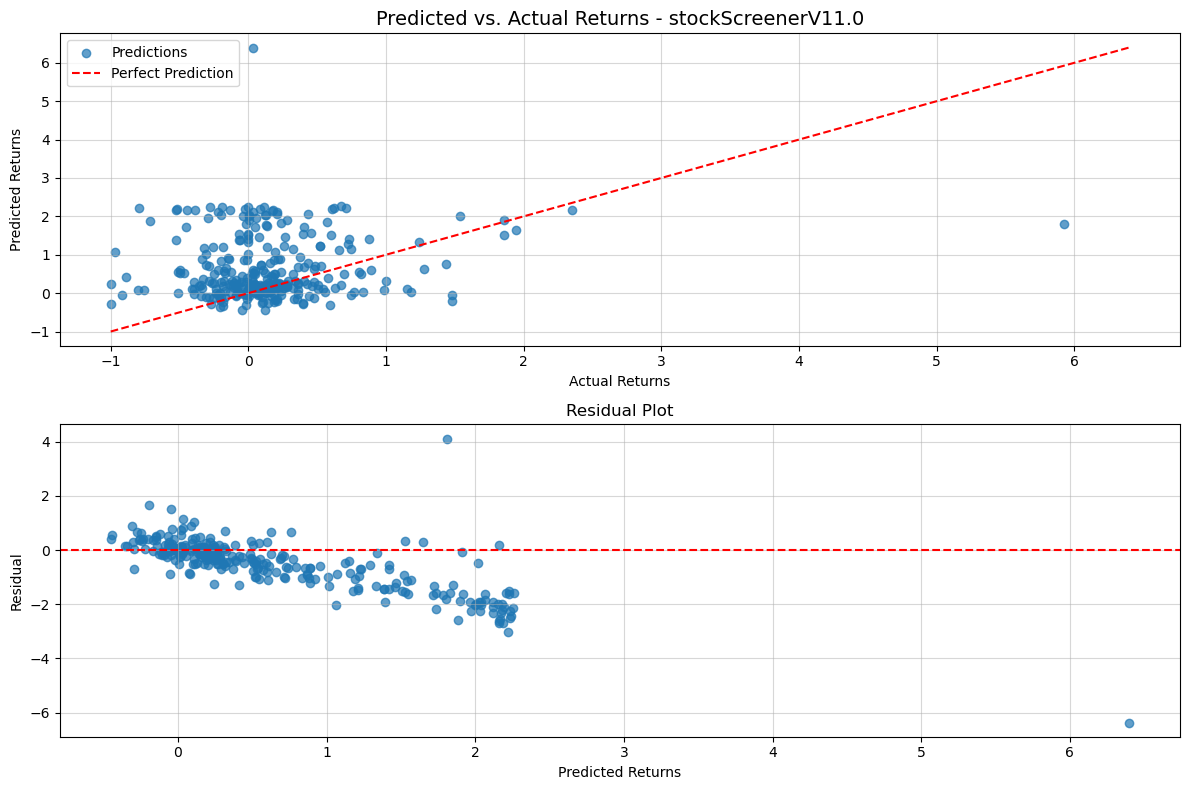

Collected 300 valid test tickers (target: 300)

Evaluation Results:
MAE: 0.709
RMSE: 1.057
R²: -2.524


In [55]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def evaluateModel(learn, test_data, model_name, model_folder, cont_names, cat_names):
    """Evaluate model on pre-collected test data"""
    # Clean data
    test_data_clean = test_data.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(model_name, mae, rmse, r2, model_folder, test_data_clean['Ticker'].unique())
    plotResults(results_df, model_name, model_folder)
    
    return mae, rmse, r2

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Run evaluation
    mae, rmse, r2 = evaluateModel(
        learn=learn,
        test_data=combinedTestData,
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Tests

In [56]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV6.0.pkl
stockScreenerV4.1.pkl
stockScreenerV4.0.pkl
stockScreenerV2.0.pkl
stockScreenerV5.1.pkl
stockScreenerV5.0.pkl
stockScreenerV5.2.pkl
stockScreenerV5.3.pkl
stockScreenerV3.0.pkl
stockScreenerV5.4.pkl
stockScreenerV1.0.pkl
stockScreenerV11.0.pkl
stockScreenerV8.0.pkl
stockScreenerV8.1.pkl
stockScreenerV8.3.pkl
stockScreenerV10.0.pkl
stockScreenerV8.2.pkl


In [57]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV5.0
Timestamp      2025-01-21 21:03
MAE                       0.237
RMSE                      0.302
R2                       -0.002
Name: 5, dtype: object

### Load model

In [58]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

## Predictions

In [59]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

predictionTarget = '8%'

Prediction for NVO (Novo Nordisk A/S):
51.46%
Free money?!
